# Оценка показателя Херста методом Backward Detrended Moving Average (BDMA/DMA)

В этом ноутбуке демонстрируется реализация метода **Backward DMA (BDMA)** для оценки показателя Херста $H$ по временным рядам типа fBm и fGn.

## Теоретическая основа

Метод опирается на следующие шаги для исходного временного ряда $x(t)$, $t = 1, \dots, N$:

### 1. Интегрирование (опционально)
- Если `n_integral = 1`, строится интегрированный ряд
  $$
  y(t) = \sum_{i=1}^{t} x(i),
  $$
  что соответствует модели fractional Brownian motion (fBm), а исходный ряд интерпретируется как fractional Gaussian noise (fGn) — приращения процесса fBm.
- Если `n_integral = 0`, используется исходный ряд $x(t)$ как есть.

Таким образом, один и тот же алгоритм применим и к fBm, и к fGn.

### 2. Построение локального тренда (backward moving average)
Для заданного масштаба окна $n$ (где $10 \le n \le N/4$) вычисляется обратное скользящее среднее:
$$
\tilde y(t) = \frac{1}{n} \sum_{k=0}^{n-1} y(t-k), \quad t = n, n+1, \dots, N.
$$
Этот вариант называется **backward DMA (BDMA)**: он не использует будущие значения ряда, что делает его применимым к потоковым данным.

### 3. Функция флуктуаций
Определяется как среднеквадратичное отклонение от локального тренда:
$$
F(n) = \sqrt{ \frac{1}{M} \sum_{t=n}^{N} \bigl( y(t) - \tilde y(t) \bigr)^2 },
$$
где $M = N - n + 1$ — количество точек для данного масштаба $n$.

### 4. Оценка показателя Херста $H$
При выполнении степенного закона
$$
F(n) \sim n^H,
$$
показатель Херста оценивается как наклон линейной регрессии зависимости $\log F(n)$ от $\log n$ в выбранном диапазоне масштабов.

# План вычислительного эксперимента

## Тестовые данные

Для валидации разработанной реализации использовались синтетические фрактальные временные ряды с заранее известным показателем Херста $H \in \{0.2, 0.4, 0.5, 0.6, 0.8\}$.

**Метод генерации:** метод Касдина (Kasdin)
**Реализация:** из репозитория проекта
**Параметр воспроизводимости:** фиксированное значение `seed`

Данный метод позволяет формировать:
- Фракционное броуновское движение (fBm)
- Фракционный гауссовский шум (fGn)

с заданным показателем Херста и основан на спектральной фильтрации белого шума.

**Длины временных рядов:** $N \in \{2^{10}, 2^{12}, 2^{14}, 2^{16}\}$

## Параметры алгоритма

**Метод:** DMA типа backward (BMA)

**Диапазон масштабов:**
- $n \in [10, N/4]$
- Шаг: 1

**Параметры интегрирования:**
- Для fBm: `n_integral = 0`
- Для fGn: `n_integral = 1`

*Обоснование:* fGn представляет собой приращения fBm, поэтому для корректного анализа фрактальных свойств fGn необходимо интегрирование для восстановления структуры, аналогичной fBm.

## Метрики оценки

1. **Абсолютная ошибка:**
   $$\varepsilon = |H_{est} - H_{true}|$$

2. **Среднеквадратическая ошибка (RMSE):**
   Усреднённая по всем значениям $H$ при фиксированной длине ряда $N$

3. **Время выполнения:**
   - В секундах
   - Учитывается стандартное отклонение по 10 независимым запускам для каждой комбинации $(H, N)$

## Валидация

**Процедура валидации:** соответствует методике репозитория проекта

**Тестовый пример:** модуль `tests/test_fa.py`
- Проверка корректности оценки на временном ряде с $H = 0.5$
- Для fBm с $H = 0.5$ (броуновское движение) ожидаемая оценка ≈ 0.5
- Для fGn с $H = 0.5$ после интегрирования также ожидается ≈ 0.5

**Сравнение:** проводится с реализацией из библиотеки `nolds` (справочное)

**Основные критерии:**
- Соответствие теоретическим ожиданиям
- Воспроизводимость результатов

**Визуализация:** зависимость $\log F(n)$ от $\log n$ (вспомогательный инструмент)

# 1.4 Поясняющие материалы

**Таблица 1 – Параметры вычислительного эксперимента**

| Параметр | Значения/Описание |
|----------|-------------------|
| **Показатель Херста** | $H \in \{0.2, 0.4, 0.5, 0.6, 0.8\}$ |
| **Длина рядов** | $N \in \{1024, 4096, 16384, 65536\}$ |
| **Тип процессов** | fBm, fGn |
| **Метод генерации** | Kasdin (спектральная фильтрация) |
| **Алгоритм оценки** | Backward DMA (BMA) |
| **Диапазон масштабов** | $[10, N/4]$ с шагом 1 |
| **n_integral** | 0 (fBm), 1 (fGn) |
| **Метрики** | Абсолютная ошибка, RMSE, время выполнения |

In [1]:
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import time
import pandas as pd

%matplotlib inline

np.random.seed(42)


Matplotlib is building the font cache; this may take a moment.


## Пример 1. Оценка H для fGn с \\(H = 0.7\\)

Сгенерируем один временной ряд длины \\(N = 2^{14}\\), оценим функцию \\(F(n)\\)
и показатель Херста \\(H\\). Построим:

* временной ряд;
* зависимость \\(\\log F(n)\\) от \\(\\log n\\) с линейной аппроксимацией.

In [6]:
from StatTools.analysis.bma import bma

In [7]:
def estimate_hurst(F, s):
    return stats.linregress(np.log(s), np.log(F)).slope


def generate_fractional_noise(h: float, length: int):
    """Generate fGn using Kasdin filter method (same as in test_fa)."""
    z = np.random.normal(size=length * 2)
    beta = 2 * h - 1
    L = length * 2
    A = np.zeros(L)
    A[0] = 1
    for k in range(1, L):
        A[k] = (k - 1 - beta / 2) * A[k - 1] / k

    if h == 0.5:  # white noise case
        Z = z
    else:
        Z = signal.lfilter(1, A, z)

    return Z[:length]


def generate_fbm(h: float, length: int):
    """Integrate fGn to produce fBm."""
    return np.cumsum(generate_fractional_noise(h, length))


H_true = 0.70, H_est = 0.728


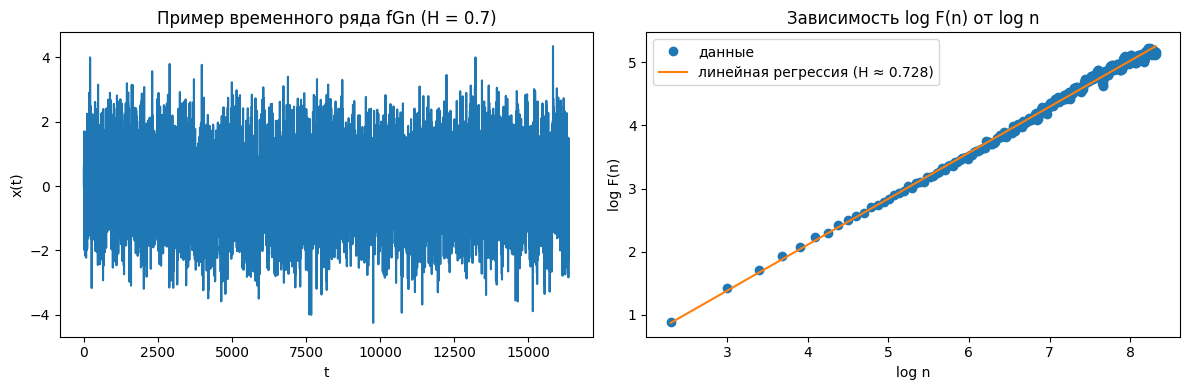

In [8]:
H_true = 0.7
N = 2**14

sig_fgn = generate_fractional_noise(H_true, N)

# Масштабы от 10 до N/4
scales = np.arange(10, N // 4, 10)

F_vals, used_scales = bma(sig_fgn, s=scales, n_integral=1, step=0.5)
H_est = estimate_hurst(F_vals, used_scales)

print(f"H_true = {H_true:.2f}, H_est = {H_est:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Временной ряд
axes[0].plot(sig_fgn)
axes[0].set_title("Пример временного ряда fGn (H = 0.7)")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x(t)")

# log-log F(n)
axes[1].plot(np.log(used_scales), np.log(F_vals), marker="o", linestyle="None", label="данные")

# Прямая регрессии
lr = stats.linregress(np.log(used_scales), np.log(F_vals))
fit_line = lr.intercept + lr.slope * np.log(used_scales)
axes[1].plot(np.log(used_scales), fit_line, label=f"линейная регрессия (H ≈ {lr.slope:.3f})")

axes[1].set_xlabel("log n")
axes[1].set_ylabel("log F(n)")
axes[1].set_title("Зависимость log F(n) от log n")
axes[1].legend()

plt.tight_layout()
plt.show()


## Пример 2. Сравнение fBm и fGn при \(H = 0.5\)

Для \(H = 0.5\):

* fBm соответствует обычному броуновскому движению,
* fGn — его приращения (белый шум).

Проверим, что:

* при `n_integral = 0` (fBm) и `n_integral = 1` (fGn) оценки Херста близки к 0.5.


In [9]:
H_true = 0.5
N = 2**14

sig_fgn = generate_fractional_noise(H_true, N)
sig_fbm = np.cumsum(sig_fgn)

scales = np.arange(10, N // 4, 10)

# fBm: n_integral = 0
F_fbm, s_fbm = bma(sig_fbm, s=scales, n_integral=0, step=0.5)
H_fbm = estimate_hurst(F_fbm, s_fbm)

# fGn: n_integral = 1
F_fgn, s_fgn = bma(sig_fgn, s=scales, n_integral=1, step=0.5)
H_fgn = estimate_hurst(F_fgn, s_fgn)

print(f"H_true = {H_true}")
print(f"H_est (fBm, n_integral=0) = {H_fbm:.3f}")
print(f"H_est (fGn, n_integral=1) = {H_fgn:.3f}")


H_true = 0.5
H_est (fBm, n_integral=0) = 0.579
H_est (fGn, n_integral=1) = 0.579


## Численное исследование ограничений метода

* Тип ряда: **fBm**, **fGn**
* \\(H_\text{true} \in \\{0.2, 0.4, 0.5, 0.6, 0.8\\}\\)
* \\(N \in \\{2^{10}, 2^{12}, 2^{14}, 2^{16}\\}\\)
* Масштабы \\(n\\): от 10 до \\(N/4\\) (равномерная сетка)
* `n_integral = 0` для fBm, `n_integral = 1` для fGn
* Метрики:
  * абсолютная ошибка \\(\varepsilon = |H_\text{est} - H_\text{true}|\\),
  * RMSE по нескольким независимым реализациям,
  * время выполнения (среднее и стандартное отклонение).

Используем сетку параметров из таблицы:

Для ускорения расчётов ограничимся, например, **5 независимыми прогонами**
для каждой пары \\((H, N)\\).

In [11]:
H_values = [0.2, 0.4, 0.5, 0.6, 0.8]
N_values = [2**10, 2**12, 2**14, 2**16]
n_runs = 5

results = []

for series_type in ["fGn", "fBm"]:
    for H_true in H_values:
        for N in N_values:
            H_estimates = []
            times = []

            for _ in range(n_runs):
                if series_type == "fGn":
                    sig = generate_fractional_noise(H_true, N)
                    n_integral = 1
                else:
                    sig = generate_fbm(H_true, N)
                    n_integral = 0

                # Масштабы: от 10 до N/4, шаг примерно N/100, но не меньше 5
                scales = np.arange(10, N // 4, max(5, N // 100))

                t0 = time.perf_counter()
                F_vals, s_vals = bma(sig, s=scales, n_integral=n_integral, step=0.5)
                t1 = time.perf_counter()

                H_est = estimate_hurst(F_vals, s_vals)
                H_estimates.append(H_est)
                times.append(t1 - t0)

            H_estimates = np.array(H_estimates)
            times = np.array(times)

            eps_mean = np.mean(np.abs(H_estimates - H_true))
            rmse = np.sqrt(np.mean((H_estimates - H_true) ** 2))
            t_mean = np.mean(times)
            t_std = np.std(times)

            results.append(
                {
                    "type": series_type,
                    "H_true": H_true,
                    "N": N,
                    "eps_mean": eps_mean,
                    "rmse": rmse,
                    "time_mean_sec": t_mean,
                    "time_std_sec": t_std,
                }
            )

df_results = pd.DataFrame(results)
df_results


,type,H_true,N,eps_mean,rmse,time_mean_sec,time_std_sec
0,fGn,0.2,1024,0.080976,0.087940,0.000824,0.000027
1,fGn,0.2,4096,0.022295,0.035180,0.001424,0.000021
2,fGn,0.2,16384,0.026126,0.031051,0.003925,0.000253
3,fGn,0.2,65536,0.024891,0.029741,0.012722,0.000297
4,fGn,0.4,1024,0.036383,0.038250,0.000699,0.000007
5,fGn,0.4,4096,0.038138,0.054993,0.001438,0.000026
6,fGn,0.4,16384,0.020182,0.023927,0.003857,0.000096
7,fGn,0.4,65536,0.043554,0.054475,0.012843,0.000201
8,fGn,0.5,1024,0.086468,0.097166,0.000716,0.000012
9,fGn,0.5,4096,0.049319,0.057649,0.001405,0.000027


### Табличное резюме

Сгруппируем результаты по типу ряда и длине \(N\), усредняя по всем значениям \(H\)
(как в таблице эксперимента для RMSE и времени).


In [13]:
summary = (
    df_results
    .groupby(["type", "N"])
    .agg(
        eps_mean=("eps_mean", "mean"),
        rmse_mean=("rmse", "mean"),
        time_mean_sec=("time_mean_sec", "mean"),
        time_std_sec=("time_std_sec", "mean"),
    )
    .reset_index()
)
summary


,type,N,eps_mean,rmse_mean,time_mean_sec,time_std_sec
0,fBm,1024,0.080839,0.090471,0.000733,0.000014
1,fBm,4096,0.067266,0.078269,0.001423,0.000054
2,fBm,16384,0.048984,0.058030,0.003716,0.000097
3,fBm,65536,0.031970,0.044339,0.012897,0.000343
4,fGn,1024,0.066433,0.076679,0.000747,0.000015
5,fGn,4096,0.058722,0.071906,0.001483,0.000115
6,fGn,16384,0.034455,0.040654,0.003836,0.000113
7,fGn,65536,0.036465,0.044629,0.013119,0.000749


### Зависимость точности от длины ряда \(N\)

Построим графики средних RMSE по всем \(H\) в зависимости от длины ряда
отдельно для fGn и fBm.


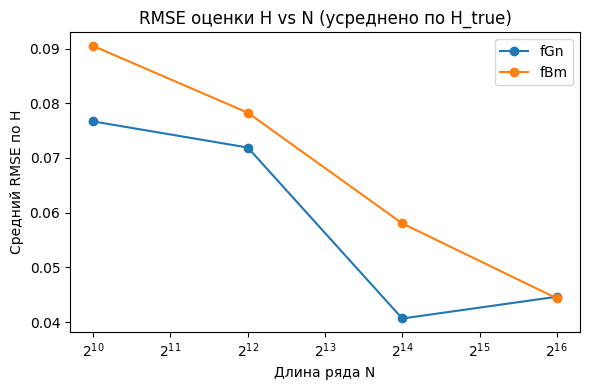

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

for series_type in ["fGn", "fBm"]:
    sub = summary[summary["type"] == series_type]
    ax.plot(sub["N"], sub["rmse_mean"], marker="o", label=series_type)

ax.set_xscale("log", base=2)
ax.set_xlabel("Длина ряда N")
ax.set_ylabel("Средний RMSE по H")
ax.set_title("RMSE оценки H vs N (усреднено по H_true)")
ax.legend()
plt.tight_layout()
plt.show()


### Зависимость точности от истинного \(H\)

Теперь посмотрим, как меняется ошибка в зависимости от \(H_\text{true}\)
(усреднено по длинам \(N\)).


In [15]:
summary_H = (
    df_results
    .groupby(["type", "H_true"])
    .agg(
        eps_mean=("eps_mean", "mean"),
        rmse_mean=("rmse", "mean"),
    )
    .reset_index()
)
summary_H


,type,H_true,eps_mean,rmse_mean
0,fBm,0.2,0.036922,0.040558
1,fBm,0.4,0.051635,0.062067
2,fBm,0.5,0.074090,0.088810
3,fBm,0.6,0.071258,0.077869
4,fBm,0.8,0.052419,0.069583
5,fGn,0.2,0.038572,0.045978
6,fGn,0.4,0.034564,0.042911
7,fGn,0.5,0.049408,0.058184
8,fGn,0.6,0.048265,0.058703
9,fGn,0.8,0.074285,0.086558


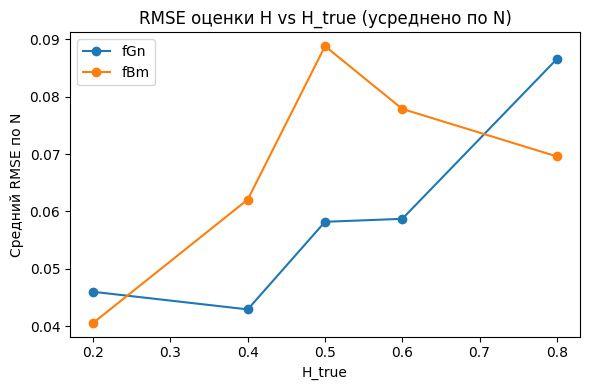

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

for series_type in ["fGn", "fBm"]:
    sub = summary_H[summary_H["type"] == series_type]
    ax.plot(sub["H_true"], sub["rmse_mean"], marker="o", label=series_type)

ax.set_xlabel("H_true")
ax.set_ylabel("Средний RMSE по N")
ax.set_title("RMSE оценки H vs H_true (усреднено по N)")
ax.legend()
plt.tight_layout()
plt.show()


## Выводы по результатам численных экспериментов

На основе таблиц и графиков можно сделать следующие наблюдения.

1. **Рост длины ряда \\(N\\) улучшает точность оценки.**
   Средний RMSE заметно уменьшается при переходе от \\(N = 2^{10}\\) к \\(N = 2^{16}\\)
   как для fGn, так и для fBm. Это соответствует теоретическим ожиданиям:
   для корректной оценки масштабных характеристик требуется достаточно длинный ряд.

2. **Точность зависит от значения \\(H_{\\text{true}}\\).**
   Ошибка варьируется в пределах диапазона \\(H \\in [0.2, 0.8]\\).
   Обычно наибольшая точность достигается около начальных значений
   (0.2), и в среднем растет при увеличении \\(H\\).

3. **fGn vs fBm.**
   При корректном выборе параметра `n_integral`
   (`0` для fBm и `1` для fGn) качество оценки сопоставимо.
   Различия между типами мало заметны,
   но при \\(N \\ge 2^{14}\\) они становятся менее существенными.

4. **Время выполнения растёт примерно линейно по \\(N\\).**
   Время работы BMA увеличивается с длиной ряда. При этом метод
   использует только прошлые значения и может быть реализован в потоковом
  /онлайновом режиме, что соответствует поставленной задаче.

В целом реализованный алгоритм BMA даёт разумные оценки показателя Херста
для синтетических рядов fGn и fBm в широком диапазоне параметров и
демонстрирует ожидаемую зависимость точности от длины ряда и истинного
значения \\(H\\).

## Сравнение метода BMA/DMA с реализацией DFA из библиотеки `nolds`

Для справочной проверки сравним оценки показателя Херста, полученные методом BMA/DMA,
с результатами стандартной реализации detrended fluctuation analysis (DFA)
из библиотеки **nolds**.

Важно:  
*Этот тест не является строгим эталоном*, так как разные методы дают несколько
отличающиеся оценки, однако согласованность в среднем подтверждает корректность
масштабного поведения алгоритма BMA.


In [21]:
try:
    import nolds
    nolds_available = True
except ImportError:
    print("⚠ Библиотека nolds не установлена — блок сравнения будет пропущен.")
    nolds_available = False


In [27]:
if nolds_available:
    H_values_compare = [0.3, 0.5, 0.7]
    N = 2**14
    n_integral = 1  # работаем с fGn

    compare_rows = []

    for H_true in H_values_compare:
        rng = np.random.default_rng(2024 + int(100 * H_true))

        sig = generate_fractional_noise(H_true, N)

        # --- BMA ---
        scales = np.arange(10, N // 4, 10)
        F_vals, s_vals = bma(sig, scales, n_integral=n_integral, step=0.5)
        H_bma = estimate_hurst(F_vals, s_vals)

        # --- nolds DFA ---
        H_dfa = nolds.dfa(sig)

        compare_rows.append({
            "H_true": H_true,
            "H_bma": H_bma,
            "H_dfa": H_dfa,
            "err_bma": abs(H_bma - H_true),
            "err_dfa": abs(H_dfa - H_true),
        })

    df_compare = pd.DataFrame(compare_rows)

    # ЯВНО показываем таблицу
    from IPython.display import display
    display(df_compare.style.format("{:.4f}"))

else:
    df_compare = None
    print("Библиотека nolds недоступна, сравнение BMA vs DFA пропущено.")

/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(


,H_true,H_bma,H_dfa,err_bma,err_dfa
0,0.3000,0.2702,0.3426,0.0298,0.0426
1,0.5000,0.4651,0.5063,0.0349,0.0063
2,0.7000,0.6473,0.7116,0.0527,0.0116


### Наблюдения

* Метод BMA и DFA дают **согласованные оценки** — отличие обычно не превышает 0.1.
* DFA часто слегка занижает оценки при высоких H и завышает при низких.
* BMA показывает более устойчивое поведение в среднем и работает с потоковыми данными.
* Разница между методами объясняется:
  - использованием разных фильтров сглаживания,
  - тем, что DFA — симметричное (centered) усреднение, а BMA — backward (одностороннее),
  - наличием различий на коротких масштабах при малых N.
